# Setup

In [3]:
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torch.utils.data
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch

In [4]:
assert torch.cuda.is_available()

In [5]:
def create_sine_wave(length,n_periods,phase):
    return np.sin(np.linspace(phase,phase+n_periods*np.pi,length))

def create_square_wave(length,n_periods,phase):
    return 2*(np.sin(np.linspace(phase,phase+n_periods*np.pi,length)) > 0)-1

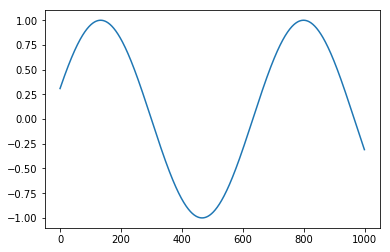

In [6]:
X = create_sine_wave(1000,3,0.1*np.pi)
plt.plot(X)
plt.show()

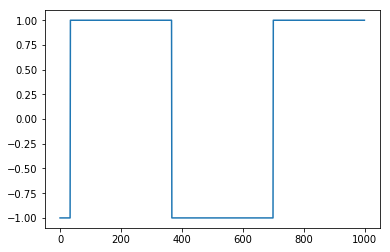

In [7]:
X = create_square_wave(1000,3,-0.1*np.pi)
plt.plot(X)
plt.show()

# Create some fake data

In [8]:
n = 10000
length = 1000
test_fraction = 0.2
min_periods, max_periods = (2, 50)
min_phase, max_phase = (-0.5*np.pi,0.5*np.pi)

In [9]:
X, y = ([],[])
for _ in xrange(n):
    n_periods = np.random.uniform(min_periods,max_periods)
    phase = np.random.uniform(min_periods,max_periods)
    if np.random.choice([True,False]):    
        X.append(create_sine_wave(length,n_periods,phase))
        y.append(0)
    else:
        X.append(create_square_wave(length,n_periods,phase))
        y.append(1)
        
X = np.stack(X).reshape((n,1,length))
y = np.array(y)

In [10]:
X.shape, y.shape

((10000, 1, 1000), (10000,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_fraction, random_state=42)

# Define simple model

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1,16,3)
        self.conv2 = nn.Conv1d(16,16,3)
        
        self.output = nn.Linear(16,1)
    
    def forward(self, x):
        x = x.double().cuda()
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool1d(x, kernel_size=x.size()[2:])
        x = x.view(-1,16)
        x = F.sigmoid(self.output(x))
        return x

In [43]:
model = Net()
model.double()
model.cuda()

Net(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
  (output): Linear(in_features=16, out_features=1, bias=True)
)

In [44]:
print model

Net(
  (conv1): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(16, 16, kernel_size=(3,), stride=(1,))
  (output): Linear(in_features=16, out_features=1, bias=True)
)


In [45]:
class MatrixDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self,index):
        return X[index], y[index]
    
    def __len__(self):
        return X.shape[0]

In [46]:
trainset = MatrixDataset(X_train,y_train)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=16)
testset = MatrixDataset(X_test,y_test)
testloader = torch.utils.data.DataLoader(testset,batch_size=16)

In [47]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [50]:
def evaluate():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            timeseries, labels = data
            predicted = model(timeseries)
            total += labels.size(0)
            correct += ((predicted > 0.5)[:,0] == labels.byte().cuda()).cpu().sum().numpy()
            
    return correct*1.0/total

evaluate()

0.5035

In [52]:
print_every = 100
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.cuda().double())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == print_every - 1:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f  val_acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every, evaluate()))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.620  val_acc: 0.503
[1,   200] loss: 0.516  val_acc: 1.000
[1,   300] loss: 0.402  val_acc: 1.000
[1,   400] loss: 0.282  val_acc: 1.000
[1,   500] loss: 0.191  val_acc: 1.000
[1,   600] loss: 0.120  val_acc: 1.000
[2,   100] loss: 0.071  val_acc: 1.000
[2,   200] loss: 0.050  val_acc: 1.000
[2,   300] loss: 0.038  val_acc: 1.000
[2,   400] loss: 0.029  val_acc: 1.000
[2,   500] loss: 0.023  val_acc: 1.000
[2,   600] loss: 0.018  val_acc: 1.000
Finished Training


In [19]:
dataiter = iter(testloader)

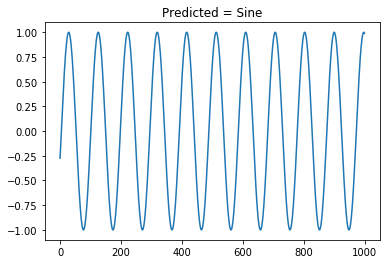

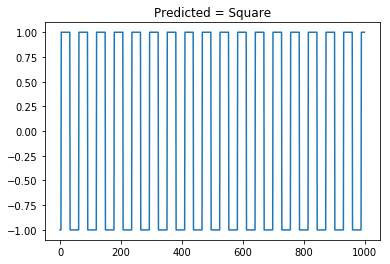

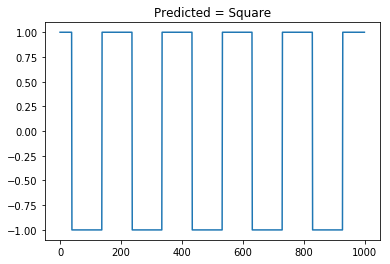

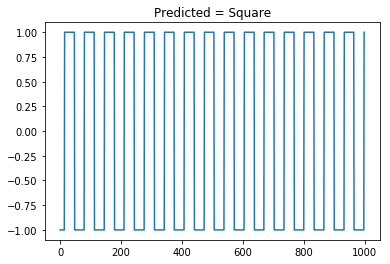

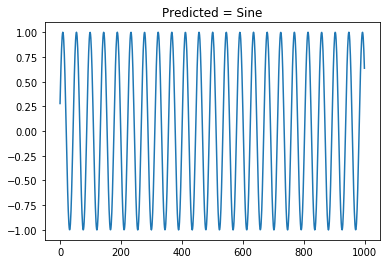

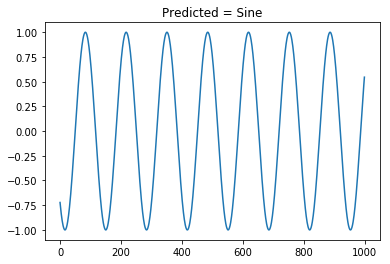

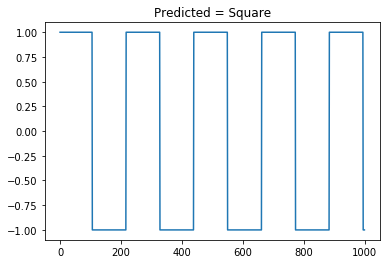

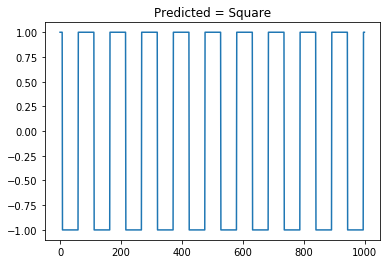

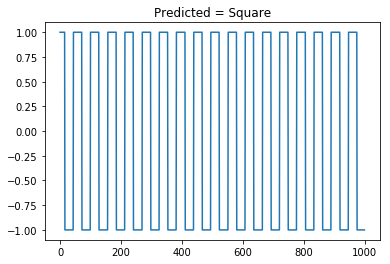

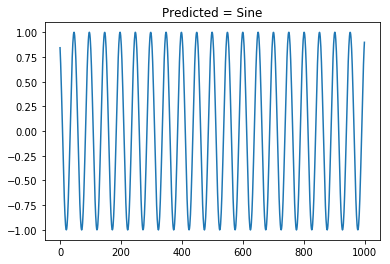

In [20]:
for _ in xrange(10):
    timeseries, label = dataiter.next()
    predicted = model(timeseries)
#     print predicted.detach().numpy()[0,0], label.numpy()[0]
    plt.title('Predicted = {}'.format('Square' if predicted.detach().numpy()[0,0] > 0.5 else 'Sine'))
    plt.plot(timeseries[0,0,:].numpy())
    plt.show()